In [2]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv("data_input/Female Daily Skincare Review Final.csv")

In [4]:
data.isna().sum()

Reviewer       2
Recommend      0
Stars          0
Date           0
Product        0
Category       0
Date Scrape    0
Url            0
dtype: int64

In [5]:
data = data.dropna()

In [6]:
data.duplicated().sum()
data.drop_duplicates(keep = "first", inplace = True)

In [7]:
id_count = pd.crosstab(index=data.Reviewer,columns='count').sort_values(by='count',ascending=True)

In [8]:
name_r = id_count[id_count['count']>1]
name_u = name_r.index.to_list()
data = data[data.Reviewer.isin(name_u)]
data.to_csv('femdaily.csv',index=False,header=True)

Data Exploration

In [9]:
data = pd.read_csv("femdaily.csv")
data = data.dropna()
data.drop_duplicates(keep = "first", inplace = True)
data.drop(['Recommend','Date','Date Scrape','Url','Category'], axis=1, inplace=True)
data.rename(columns={'Reviewer':'reviewer','Product':'product','Stars':'rating'}, inplace=True)

In [10]:
data

,reviewer,rating,product
0,Ayuika,3,Perfect 3D Gel
1,yustinalupit,4,Perfect 3D Gel
2,evikdanny,3,Perfect 3D Gel
3,daniskhoirun,3,Perfect 3D Gel
4,hulahup19,5,Perfect 3D Gel
...,...,...,...
137295,steph91,4,Ultra Rapid Action Pad
137296,farishaalamsyah,1,Ultra Rapid Action Pad
137297,imeldanababan,4,Ultra Rapid Action Pad
137298,princessvie,3,Ultra Rapid Action Pad


In [11]:
uniq_product = data['product'].nunique()
print("Number of uniq product :",uniq_product)

Number of uniq product : 3297


In [12]:
uniq_reviewer = data['reviewer'].nunique()
print("Number of uniq reviewer :",uniq_reviewer)

Number of uniq reviewer : 22360


(array([2.0000e+00, 0.0000e+00, 5.1490e+03, 0.0000e+00, 1.1718e+04,
        0.0000e+00, 2.6712e+04, 0.0000e+00, 4.2250e+04, 5.1469e+04]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

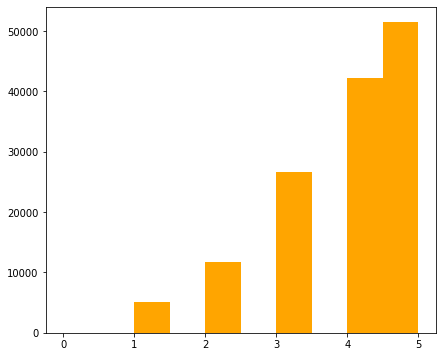

In [13]:
plt.subplots(figsize = (7,6))
plt.hist(data['rating'],color="orange")

In [14]:
#how many time product has been given stars by reviewer
prod_freq = pd.crosstab(index = data['product'], columns = "freq_of_product").sort_values(ascending=False, by="freq_of_product").\
            head(10).reset_index()
prod_freq

col_0,product,freq_of_product
0,Real Nature Mask Sheet,932
1,7 Days Mask,642
2,My Real Squeeze Mask,635
3,It's Real Squeeze Mask,585
4,Milk Cleanser,580
5,Facial Mask,492
6,Face Tonic,473
7,Masquerade Face Mask,470
8,Collagen Essence Mask,452
9,Pore Pack,405


Recommender

In [102]:
matrix_pivot = pd.pivot_table(data,values='rating',index='reviewer',columns='product').fillna(0)
matrix_pivot.head()

product,"0,2 mm Therapy Air Mask Sheet",10% Lactic Acid (Infused with Rose),100% Cold-Pressed Virgin Marula Oil,100% Organic Cold-Pressed Borage Seed Oil,100% Organic Cold-Pressed Rose Hip Seed Oil,100% Plant-Derived Squalane,100% Pure Camellia Dry Oil,100% Snail mucus Soothing Gel,14% AHA Swipes,2 Minutes Brightening Gel,24K Bio Gold Night Cream,24K Bio-Gold Rose Gold Water,24K Gold Premium First Essence,24K Gold Pure Luxury Cleansing Butter,24k Bio Gold Gold Water,25% mandelic acid peel,3 Step Nose Clear Pad,30% Mandelic Acid Anti-Acne Gel,7 Day Scrub Cream,7 Days Mask,8% Alpha Hydroxy Acid Gel,9 to 5,95% Watermelon Soothing Gel,98% Watermelon Soothing Gel,99% ALOE SOOTHING GEL,99% Aloe Vera Gelly,99% Jeju Fresh Aloe Soothing Gel,99% Snail and Gold Soothing Gel,@haple.id Almond Oil and Grapeseed Oil,A Perfect World Deep Cleanser,A'BLOOM Anti Blemish Peach Mask,A'BLOOM Brightening Lemon Lime Mask,A'BLOOM Moisturizing Watermelon Mask,A'PIEU Madecassoside Cream,A:PE Proatin Mask,AC Clean Up Gel Lotion,AC Clean Up Pink Powder Mask,AC Clean Up Toner,AC Clean up,AC Clinic Daily Gel Lotion,...,off with those heads,olive real oil mist EX,orange sleeping mask,oxy10 maximum acne pimple medication,perfect hydrating treatment esence,pond's glitter cream,pulchra.id,pure balance hydro gel moisturizer,pure source pocket pack,qiansoto peel off masque,real nature mask sheet,runaskin peel off,serum envygreen,shoppasoap cleansing balm,silcot maximizer cotton,skin &amp; lab gently vita exfoliator,snail shooting gel the saem,some by mi,thayers alcohol free toner,the body shop tea tree serum,the littles kit,the polished,the water cream,ultimate moisturising honey,uv mild milk,viva milk cleanser dan viva face tonic,viva skinfood,wardah mineral clay mask,wardah nature daily,wardah seaweed balancing facial wash,wardah seaweed intensive night cream,wardah suncare,watermelon glow,white beauty aqua facial wash with plant extract,whitening plus complex,whitening soap,wonder pore,zaitun oil,“Buffet”,“B” oil
reviewer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01lely,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01putrisalma,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01sary,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123hayoapa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
data.shape

(137300, 3)

In [104]:
matrix_pivot.shape

(22360, 3297)

In [0]:
matrix_pivot_ = matrix_pivot.values
user_ratings_mean = np.mean(matrix_pivot_, axis = 1)
user_rating = matrix_pivot_ - user_ratings_mean.reshape(-1,1)


In [0]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(matrix_pivot_, k = 50)

In [0]:
sigma = np.diag(sigma)

In [0]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [109]:
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = matrix_pivot.columns, index=matrix_pivot.index)
preds_df

product,"0,2 mm Therapy Air Mask Sheet",10% Lactic Acid (Infused with Rose),100% Cold-Pressed Virgin Marula Oil,100% Organic Cold-Pressed Borage Seed Oil,100% Organic Cold-Pressed Rose Hip Seed Oil,100% Plant-Derived Squalane,100% Pure Camellia Dry Oil,100% Snail mucus Soothing Gel,14% AHA Swipes,2 Minutes Brightening Gel,24K Bio Gold Night Cream,24K Bio-Gold Rose Gold Water,24K Gold Premium First Essence,24K Gold Pure Luxury Cleansing Butter,24k Bio Gold Gold Water,25% mandelic acid peel,3 Step Nose Clear Pad,30% Mandelic Acid Anti-Acne Gel,7 Day Scrub Cream,7 Days Mask,8% Alpha Hydroxy Acid Gel,9 to 5,95% Watermelon Soothing Gel,98% Watermelon Soothing Gel,99% ALOE SOOTHING GEL,99% Aloe Vera Gelly,99% Jeju Fresh Aloe Soothing Gel,99% Snail and Gold Soothing Gel,@haple.id Almond Oil and Grapeseed Oil,A Perfect World Deep Cleanser,A'BLOOM Anti Blemish Peach Mask,A'BLOOM Brightening Lemon Lime Mask,A'BLOOM Moisturizing Watermelon Mask,A'PIEU Madecassoside Cream,A:PE Proatin Mask,AC Clean Up Gel Lotion,AC Clean Up Pink Powder Mask,AC Clean Up Toner,AC Clean up,AC Clinic Daily Gel Lotion,...,off with those heads,olive real oil mist EX,orange sleeping mask,oxy10 maximum acne pimple medication,perfect hydrating treatment esence,pond's glitter cream,pulchra.id,pure balance hydro gel moisturizer,pure source pocket pack,qiansoto peel off masque,real nature mask sheet,runaskin peel off,serum envygreen,shoppasoap cleansing balm,silcot maximizer cotton,skin &amp; lab gently vita exfoliator,snail shooting gel the saem,some by mi,thayers alcohol free toner,the body shop tea tree serum,the littles kit,the polished,the water cream,ultimate moisturising honey,uv mild milk,viva milk cleanser dan viva face tonic,viva skinfood,wardah mineral clay mask,wardah nature daily,wardah seaweed balancing facial wash,wardah seaweed intensive night cream,wardah suncare,watermelon glow,white beauty aqua facial wash with plant extract,whitening plus complex,whitening soap,wonder pore,zaitun oil,“Buffet”,“B” oil
reviewer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,0.007128,0.004978,0.005286,0.005990,0.014659,-0.003781,0.005696,0.007091,0.005998,0.007918,0.004748,0.008436,0.011697,0.005712,0.002092,0.005453,0.007821,0.007967,0.007570,-0.012248,0.005505,0.005613,0.004994,0.005831,0.005117,0.005348,0.008573,0.005652,0.005651,0.005173,-0.001257,-0.001178,0.008499,0.014391,0.006119,0.005569,0.003925,0.006948,0.005345,0.003491,...,0.005295,0.005355,0.005498,0.005484,0.009962,0.004867,0.003070,0.006247,0.005123,0.007123,-0.025874,0.005527,0.004676,0.005080,0.003177,0.006149,0.006998,0.004168,0.012336,0.031716,0.005465,0.004258,0.003592,0.005903,0.007621,-0.003720,0.012462,-0.009279,0.002966,0.004961,0.005122,0.003285,0.003525,0.004744,0.007140,0.007799,0.012820,0.003137,0.017110,0.004640
01lely,-0.004616,0.022427,0.024352,0.019140,0.072185,0.041747,0.020771,0.035816,0.020644,0.012761,0.027735,0.031732,0.034271,0.019703,0.107643,0.020747,0.013746,0.022512,0.045303,-0.176489,0.020367,0.020570,0.024279,0.048805,0.027103,0.019793,0.115862,0.027234,0.017348,0.019058,0.139296,0.011079,0.077645,0.057243,0.018792,0.029297,0.045801,0.036246,0.006794,0.029691,...,0.018627,0.019728,0.012872,0.007996,0.009297,0.082865,0.022752,0.035202,0.030501,0.021975,0.214977,0.020890,0.020379,0.022717,0.022147,0.021717,0.012394,0.027442,0.033776,0.000063,0.018957,0.015680,0.012305,0.018860,0.018430,0.204367,0.150191,0.283117,0.086988,0.181307,0.080692,0.127824,0.002882,0.019096,0.016598,0.013999,0.010802,0.012958,0.042780,0.021572
01putrisalma,0.012836,0.002885,0.004572,0.002653,0.022205,0.014280,0.001863,0.002167,0.001837,0.009818,0.002812,0.000040,0.002201,0.001865,-0.006247,0.002352,0.007507,0.015288,-0.009265,0.085662,0.004704,0.003112,0.002121,0.007215,0.004059,0.002362,-0.011681,0.004239,0.002059,0.002532,0.020395,0.008533,0.010919,0.049326,0.074734,0.001528,0.007853,0.006543,0.005411,0.005221,...,0.002210,0.002281,0.000905,0.004082,0.018645,0.006

In [0]:
 def recommend_product(predictions_df, user, data_,num_recommendations):
   
    user_row_number = user
    sorted_user_predictions = preds_df.loc[user_row_number].sort_values(ascending=False)

    user_data = data_[data_.reviewer == (user)]
    user_full = user_data

    print('User {0} has already rated {1} product'.format(user, user_full.shape[0]))

   
    recommendations = (data[~data['product'].isin(user_full['product'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'product',
               right_on = 'product').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [111]:
user = str(input("Enter the user id to whom you want to recommend : "))
already_rated, predictions = recommend_product(preds_df, user, data,6)

Enter the user id to whom you want to recommend : zzulia
User zzulia has already rated 3 product


In [112]:
already_rated

,reviewer,rating,product
70013,zzulia,3,Facial Mask
88179,zzulia,2,Facial Mask
115840,zzulia,5,Pembersih Two In One Bengkoang Whitening


In [0]:
prod_pred = predictions.loc[:,'product'].drop_duplicates(keep='first')

In [114]:
prod_pred

73699    Prominent Essence Facial Mask
Name: product, dtype: object